In [1]:
import numpy as np 
import pandas as pd 

In [5]:
df = pd.read_csv("TSLA_raw.csv", skiprows=2)

# Rename columns properly
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

df['Date'] = pd.to_datetime(df['Date'])
df[['Close', 'High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

df.set_index('Date', inplace=True)

print(df.dtypes)
print(df.head())


Close     float64
High      float64
Low       float64
Open      float64
Volume    float64
dtype: object
                 Close        High         Low        Open       Volume
Date                                                                   
2023-01-03  108.099998  118.800003  104.639999  118.470001  231402800.0
2023-01-04  113.639999  114.589996  107.519997  109.110001  180389000.0
2023-01-05  110.339996  111.750000  107.160004  110.510002  157986300.0
2023-01-06  113.059998  114.389999  101.809998  103.000000  220911100.0
2023-01-09  119.769997  123.519997  117.110001  118.959999  190284000.0


In [9]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

In [11]:
print(df['Target'].value_counts())


Target
1    137
0    113
Name: count, dtype: int64


In [13]:
# Simple Moving Averages
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Average
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()

# RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD and Signal Line
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

In [17]:
from sklearn.model_selection import train_test_split

df.dropna(inplace=True)

features = ['Close', 'High', 'Low', 'Open', 'Volume',
            'SMA_20', 'SMA_50', 'EMA_10', 'RSI', 'MACD', 'Signal_Line']
X = df[features]
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # No shuffling to preserve time-series order
)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize and train the model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4878048780487805

Confusion Matrix:
 [[11  6]
 [15  9]]

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.65      0.51        17
           1       0.60      0.38      0.46        24

    accuracy                           0.49        41
   macro avg       0.51      0.51      0.49        41
weighted avg       0.53      0.49      0.48        41



In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Accuracy: 0.4634146341463415

Confusion Matrix:
 [[ 2 15]
 [ 7 17]]

Classification Report:
               precision    recall  f1-score   support

           0       0.22      0.12      0.15        17
           1       0.53      0.71      0.61        24

    accuracy                           0.46        41
   macro avg       0.38      0.41      0.38        41
weighted avg       0.40      0.46      0.42        41



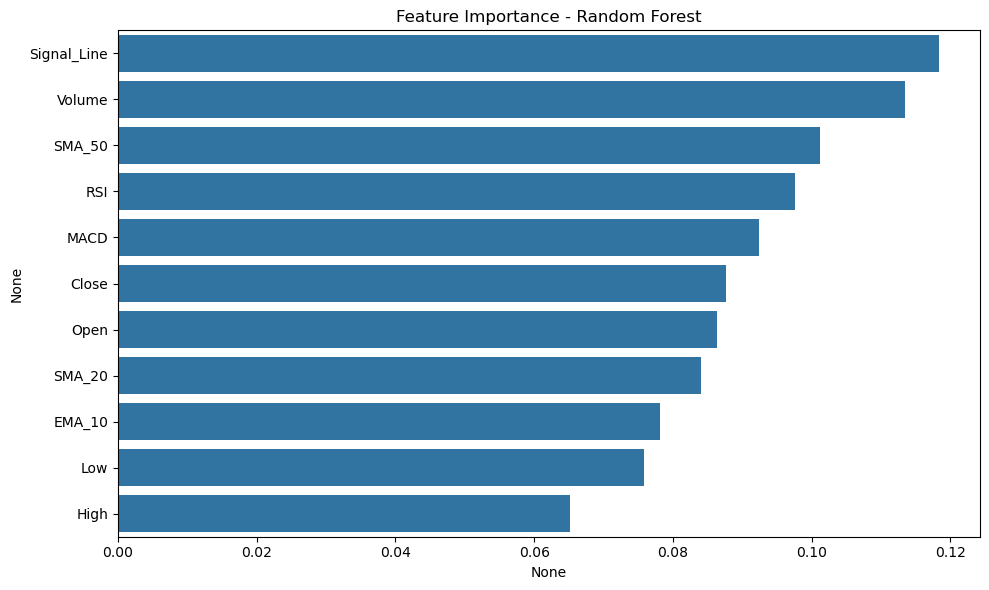

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.sort_values(ascending=False), 
            y=feature_importances.sort_values(ascending=False).index)
plt.title("Feature Importance - Random Forest")
plt.tight_layout()
plt.show()

In [25]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

xgb_model.fit(X_train, y_train)

C:\Users\ry661\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:45:26] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

Accuracy: 0.4634146341463415

Confusion Matrix:
 [[ 0 17]
 [ 5 19]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.53      0.79      0.63        24

    accuracy                           0.46        41
   macro avg       0.26      0.40      0.32        41
weighted avg       0.31      0.46      0.37        41



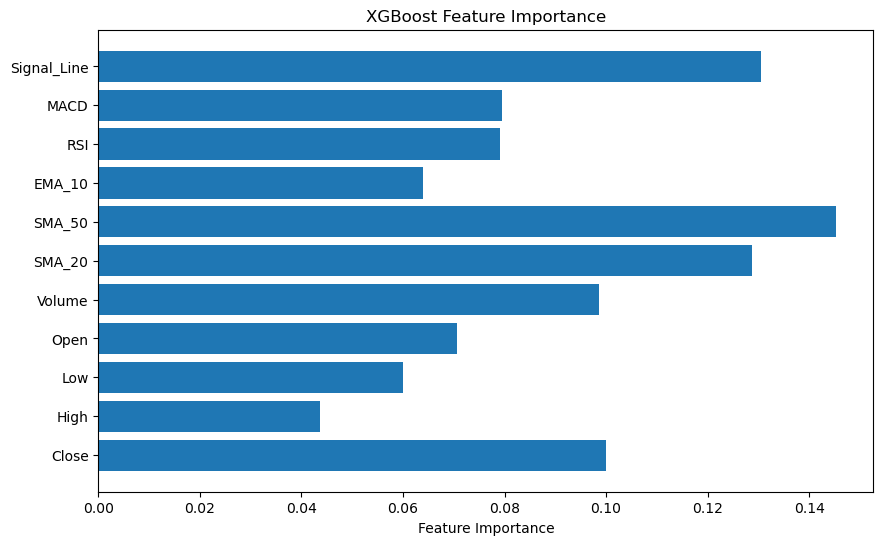

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X.columns, xgb_model.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.show()

In [31]:
# Calculate class weights
weight_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=weight_ratio,
    random_state=42
)
xgb_model.fit(X_train, y_train)

C:\Users\ry661\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:46:48] WARNING: C:\b\abs_d97hy_84m6\croot\xgboost-split_1749630932152\work\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
# Check class distribution in training set
import numpy as np

class_0_count = np.sum(y_train == 0)
class_1_count = np.sum(y_train == 1)

scale_pos_weight = class_0_count / class_1_count
print(f"Class 0: {class_0_count}, Class 1: {class_1_count}")
print(f"scale_pos_weight: {scale_pos_weight}")


Class 0: 77, Class 1: 83
scale_pos_weight: 0.927710843373494


In [37]:
y_pred = xgb_model.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4878048780487805

Confusion Matrix:
 [[ 0 17]
 [ 4 20]]

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.54      0.83      0.66        24

    accuracy                           0.49        41
   macro avg       0.27      0.42      0.33        41
weighted avg       0.32      0.49      0.38        41

